In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tqdm import tqdm

In [4]:
os.chdir("/gdrive/MyDrive/Colab_Notebooks")
cwd = os.getcwd()
print(cwd)

/gdrive/MyDrive/Colab_Notebooks


In [5]:
files = "./Mask_Data"
data_dir = pathlib.Path(files)
data_dir

PosixPath('Mask_Data')

Importation des images

*On compte le nombre d'images présentent dans le jeu de données*

In [6]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

1508


*Affichage d'une image du jeu de données*

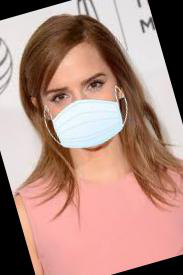

In [7]:
with_mask = list(data_dir.glob("with_mask/*"))
PIL.Image.open(str(with_mask[1]))

Traitement des images

*Importation bibliothèque cv2*

In [8]:
import cv2

*On affiche les dimensions initiales d'une image en définissant un tuple (224,224)*

In [9]:
IMG_SHAPE = (224, 224)
img = cv2.imread(str(with_mask[1]))
img.shape

(275, 183, 3)

*La fonction resize permet de redimensionner les images en 224,224,3 pour qu'elles puissent être traîtées par la méthode VGG16.*

In [10]:
cv2.resize(img, IMG_SHAPE).shape

(224, 224, 3)

*Création d'une boucle pour traiter l'intégralité des images et les adapter au même format*

Création de deux dictionnaires pour récupérer les images et leurs labels

In [11]:
mask_images_dict = {
    #La fonction glob permet d'aller chercher dans le fichiers
    'with_mask': list(data_dir.glob("with_mask/*")),
    'without_mask': list(data_dir.glob("without_mask/*"))
}

In [12]:
#On dispose de deux dossiers "with_mask" et "without_mask", on les incorpore au dictionnaire en deux labels distincts.
mask_labels_dict = {
    'with_mask':0,
    'without_mask':1
}

Création de la boucle:

In [13]:
X, y = [], []

for mask, images in mask_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMG_SHAPE)
        X.append(resized_img)
        y.append(mask_labels_dict[mask])

*Transformation des listes X et y en array*

In [14]:
X = np.array(X)
y = np.array(y)

Double split pour avoir trois sets: train, test, validation 

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=0)

In [17]:
#Normalisation des données pour que les données soient comprises entre 0 et 1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [18]:
#Y to categorical
y_train_categ = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_categ = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_val_categ = tf.keras.utils.to_categorical(y_val, num_classes=2)

Data augmentation 

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [20]:
datagen.fit(X_train)

Création du modele VGG16

In [21]:
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16()
model.summary()

In [23]:
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape = IMG_SHAPE+(3,)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [24]:
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])

In [29]:
EPOCHS = 5
checkpoint_filepath = '/gdrive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [30]:
history = model.fit(datagen.flow(X_train, y_train_categ), epochs = EPOCHS, callbacks= [model_checkpoint_callback], validation_data = (X_val, y_val_categ))

Epoch 1/5
34/34 [==============================] - 25s 726ms/step - loss: 0.0395 - acc: 0.9880 - val_loss: 0.5718 - val_acc: 0.8678
Epoch 2/5
34/34 [==============================] - 27s 805ms/step - loss: 0.0394 - acc: 0.9871 - val_loss: 0.2427 - val_acc: 0.9339
Epoch 3/5
34/34 [==============================] - 29s 843ms/step - loss: 0.0414 - acc: 0.9880 - val_loss: 0.1894 - val_acc: 0.9504
Epoch 4/5
34/34 [==============================] - 24s 690ms/step - loss: 0.0210 - acc: 0.9972 - val_loss: 0.1520 - val_acc: 0.9504
Epoch 5/5
34/34 [==============================] - 22s 634ms/step - loss: 0.0176 - acc: 0.9963 - val_loss: 0.2667 - val_acc: 0.9421


In [31]:
import matplotlib.pyplot as plt

10/10 - 5s - loss: 0.2598 - acc: 0.9338 - 5s/epoch - 485ms/step


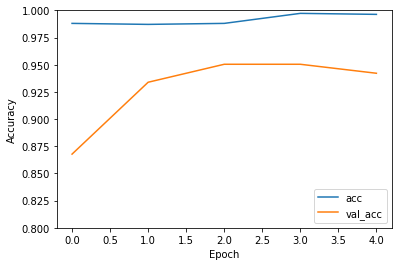

In [32]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.80, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test_categ, verbose=2)


10/10 - 3s - loss: 0.2598 - acc: 0.9338 - 3s/epoch - 291ms/step


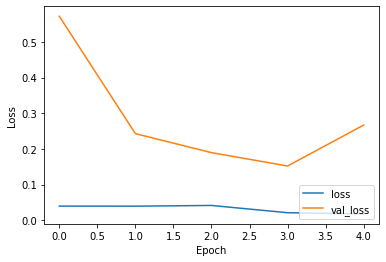

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test_categ, verbose=2)

In [34]:
pip install seaborn

In [35]:
import seaborn as sns

In [37]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis = -1)

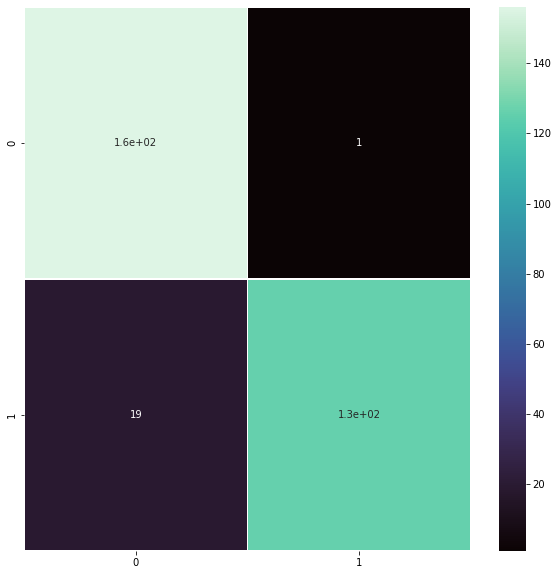

In [38]:
confusion_matrice = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
plt.figure(figsize=(10,10))

sns.heatmap(confusion_matrice, annot=True,cmap='mako', linecolor='white', linewidths=.3)

In [41]:
model.save(cwd + "/model_mask.h5", save_format="h5")